In [29]:
from astropy.table import Table
from astropy.io import fits

import numpy as np

import sys

import matplotlib
import matplotlib.pyplot as plt

from functions import logLjoint2_skew

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import skewnorm

np.set_printoptions(threshold=sys.maxsize)

In [2]:
#matplotlib.rcParams['text.usetex']=True
matplotlib.rc('font', size=18)
#matplotlib.rc('text', usetex=True)
matplotlib.rc('font', family='DejaVu Sans')

# Data

In [3]:
data_filename = '../../../../data/NSA_v1_0_1_VAGC_vflag-V2-VF.fits'

# data_old = Table.read('data_flags_updated_Oct8.dat', format = 'ascii')
#data = Table.read('data_flags_updated_Nov1.dat', format = 'ascii')
#print(len(data))
#catalog =data
hdu = fits.open(data_filename)
data = Table(hdu[1].data)
hdu.close()

## Just keep the main SDSS DR7 footprint

In [4]:
# When the catalog is the NSA, only keep those objects which were originally in the DR7 LSS
catalog_SDSS = data[data['IN_DR7_LSS'] == 1]

ra_boolean = np.logical_and(catalog_SDSS['RA'] > 110, catalog_SDSS['RA'] < 270)
catalog_north = catalog_SDSS[ra_boolean]

strip_boolean = np.logical_and.reduce([catalog_north['RA'] > 250, 
                                       catalog_north['RA'] < 269, 
                                       catalog_north['DEC'] > 51, 
                                       catalog_north['DEC'] < 67])
catalog_main = catalog_north[~strip_boolean]

In [5]:
# ra,dec,z
ra = np.array(catalog_main['RA'])
dec = np.array(catalog_main['DEC'])
z = np.array(catalog_main['Z'])

#stellar mass
#Mstar = np.array(data['Mstar'])
Mstar_NSA = np.log10(catalog_main['ELPETRO_MASS'])

# color
#u_r = np.array(data['u_r'])
# u_r = u_r[np.logical_not(np.isnan(u_r))] 
u_r_NSA = np.array(catalog_main['u_r'])

#g_r = np.array(data['g_r'])
g_r_NSA = np.array(catalog_main['g_r'])

# absolute magnitude
#rabsmag = np.array(data['rabsmag'])
rabsmag_NSA = np.array(catalog_main['ELPETRO_ABSMAG'][:,4])

# star formation rate and specific SPR
#SFR = np.array(data['SFR'])
SFR  = np.array(catalog_main['SFR'])

#sSFR = np.array(data['sSFR'])
sSFR = np.array(catalog_main['sSFR'])

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_28313/3799946246.py:8: RuntimeWarning: divide by zero encountered in log10
  Mstar_NSA = np.log10(catalog_main['ELPETRO_MASS'])


## Separate galaxies by their LSS classifications

### $V^2$

In [6]:
wall_v2 = catalog_main['vflag_V2'] == 0 #np.argwhere(data['flag_vsquared'] == 0).flatten()
void_v2 = catalog_main['vflag_V2'] == 1 #np.argwhere(data['flag_vsquared'] == 1).flatten()
edge_v2 = catalog_main['vflag_V2'] == 2 #np.argwhere(data['flag_vsquared'] == 2).flatten()
out_v2 = catalog_main['vflag_V2'] == 9 #np.argwhere(data['flag_vsquared'] == 9).flatten()

### VoidFinder

In [7]:
wall_vf = catalog_main['vflag_VF'] == 0 #np.argwhere(data['flag_voidfinder'] == 0).flatten()
void_vf = catalog_main['vflag_VF'] == 1 #np.argwhere(data['flag_voidfinder'] == 1).flatten()
edge_vf = catalog_main['vflag_VF'] == 2 #np.argwhere(data['flag_voidfinder'] == 2).flatten()
out_vf = catalog_main['vflag_VF'] == 9 #np.argwhere(data['flag_voidfinder'] == 9).flatten()

# Fit the distributions with skewnormal distributions

In [ ]:
def chi2()

In [8]:
################################################################################
#-------------------------------------------------------------------------------
"""
def func_bimodal(x, a, mua, sga, askew, b, mub, sgb, bskew):
    '''returns a mixture of two skewnormal distributions'''
    return a*skewnorm.pdf(x, askew, loc=mua, scale=sga) + b*skewnorm.pdf(x, bskew, loc=mub, scale=sgb)
"""

def func_bimodal(x, a, mua, sga, askew, b, mub, sgb, bskew):
    """
    Mixture of two skew normal distributions.
    

    Parameters
    ----------

    x : float or ndarray
        Values to calculate the model.
        
    a, b : float
        amplitudes of the skew normal distributions
        
    mua, mub : float
        locations of the skew normal distributions
        
    sga, sgb : float
        widths of the skew normal distributions
        
    askew, bskew : float
        skews of the skew normal distributions
    

    Returns
    -------
    model : float or ndarray
        Mixture model evaluated at x.
    """

    return a*skewnorm.pdf(x, askew, loc=mua, scale=sga) + \
           b*skewnorm.pdf(x, bskew, loc=mub, scale=sgb)
################################################################################




################################################################################
#-------------------------------------------------------------------------------
"""
def func_unimodal(x, a, mua, sga, askew):
    return a*skewnorm.pdf(x, askew, loc=mua, scale=sga)
"""

def func_unimodal(x, a, mu, sg, skew):
    """
    One skew normal distribution
    

    Parameters
    ----------

    x : float or ndarray
        Values to calculate the model.
        
    a : float
        amplitude of the skew normal distribution
        
    mu : float
        location of the skew normal distribution
        
    sg : float
        width of the skew normal distribution
        
    skew : float
        skew of the skew normal distribution
    

    Returns
    -------
    model : float or ndarray
        Model evaluated at x.
    """

    return a*skewnorm.pdf(x, skew, loc=mu, scale=sg)
################################################################################

In [9]:
def bin_data(data, bins_, label="label me", plot=False): 

    n1, edges1 = np.histogram(data, bins=bins_)

    dn1 = np.sqrt(n1)

    x = 0.5*(edges1[1:] + edges1[:-1])
        
    if plot:
        plt.errorbar(x, n1, yerr=dn1, fmt='.')        
        plt.xlabel(label, fontsize=18)
        plt.ylabel('count',fontsize=18) 
        plt.title(label)
        plt.show()
        
    return  x, n1, dn1 #, popt_void

In [11]:
def fit_bimodal(char_, class_, bins, p0_=None, err=None, label=''):
    
    x_data, y_data, dy = bin_data(data=char_[class_], bins_=bins)   
    
    if err is None:
        err = np.sqrt(y_data)
    else:
        err[np.argwhere(err==0)] = 0.00001
    
    #s = dy
    
    popt_, pcov_ = curve_fit(func_bimodal, x_data, y_data, p0=p0_)#, sigma=s)#, sigma=cov)
    
    ############################################################################
    # Plot distribution and best fit
    #---------------------------------------------------------------------------
    plt.errorbar(x_data, y_data, yerr=err, fmt='.')  
    plt.plot(x_data, func_bimodal(x_data, *popt_), 'k')
    plt.ylabel('Counts')
    plt.title(label)
    plt.show()
    ############################################################################
    
    print(popt_, np.sqrt(np.diag(pcov_)))
    
    return popt_, np.sqrt(np.diag(pcov_))

In [12]:
def fit_unimodal(char_, class_, bins, p0_=None, err=None, label=''):
    
    x_data, y_data, dy = bin_data(data=char_[class_], bins_=bins)
    
    if err is None:
        err = np.sqrt(y_data)
    else:
        err[np.argwhere(err==0)] = 0.00001
    
    #s = dy
    
    popt_, pcov_ = curve_fit(func_unimodal, x_data, y_data, p0=p0_)#, sigma=s)#, sigma=cov)
    
    ############################################################################
    # Plot distribution and best fit
    #---------------------------------------------------------------------------
    plt.errorbar(x_data, y_data, yerr=err, fmt='.')  
    plt.plot(x_data, func_unimodal(x_data, *popt_), 'k') #label='fit: a=%5.3f, mua=%5.3f, sga=%5.3f, askew=%5.3f, b=%5.3f, mub=%5.3f, sgb=%5.3f, bskew=%5.3f' % tuple(popt))
    plt.ylabel("Counts")
    plt.title(label)
    plt.show()
    ############################################################################
    
    print(popt_, np.sqrt(np.diag(pcov_)))
    
    return popt_, np.sqrt(np.diag(pcov_))
    

## $M_*$ mean

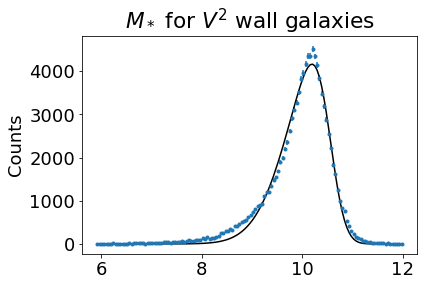

[ 4.64071485e+03  1.05393856e+01  7.27079143e-01 -2.90581646e+00] [4.04789416e+01 6.95150598e-03 1.12688324e-02 1.46176399e-01]
1184.6144515104259
2549799.4847640465


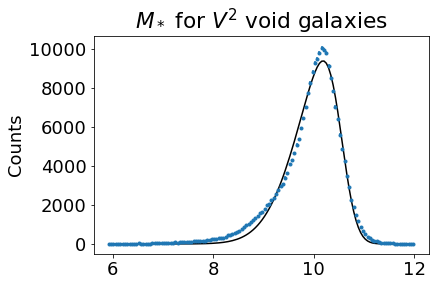

[ 1.06242945e+04  1.05357185e+01  7.42350054e-01 -2.95182331e+00] [9.51990547e+01 7.16839681e-03 1.17212223e-02 1.51937825e-01]


In [30]:
Mstar_bins = np.linspace(5.9, 12, 135)

#print("wall_v2")
x, n_V2_wall, poiss_err = bin_data(Mstar_NSA[wall_v2], bins_=Mstar_bins)
Mstar_NSA_V2_wall_fit = fit_unimodal(char_=Mstar_NSA,
                                     class_=wall_v2,
                                     bins=Mstar_bins, 
                                     err=poiss_err,
                                     p0_=[ 2000,  10.5,  1.3, 1], 
                                     label='$M_*$ for $V^2$ wall galaxies')

Mstar_NSA_V2_wall_chi2_curvefit = np.sum((n - func_unimodal(x, 
                                            Mstar_NSA_V2_wall_fit[0][0], 
                                            Mstar_NSA_V2_wall_fit[0][1], 
                                            Mstar_NSA_V2_wall_fit[0][2], 
                                            Mstar_NSA_V2_wall_fit[0][3]))**2/poiss_err**2)
Mstar_NSA_V2_wall_chi2_minimize = np.sum((n - func_unimodal(x, 
                                            4639.52, 
                                            10.61, 
                                            0.93, 
                                            -3.38))**2/poiss_err**2)
print(Mstar_NSA_V2_wall_chi2_curvefit/4)
print(Mstar_NSA_V2_wall_chi2_minimize/4)

#print("\n void_v2")
x, n_V2_void, poiss_err = bin_data(Mstar_NSA[void_v2], bins_=Mstar_bins)
Mstar_NSA_V2_void_fit = fit_unimodal(char_=Mstar_NSA, 
                                     class_=void_v2,
                                     bins=Mstar_bins, 
                                     err=poiss_err,
                                     p0_=[ 2000,  10.5,  1.3, 1], 
                                     label='$M_*$ for $V^2$ void galaxies')

In [31]:
pars = np.concatenate([Mstar_NSA_V2_wall_fit[0], Mstar_NSA_V2_void_fit[0]])
logLjoint2_skew(pars, n_V2_wall, n_V2_void, x, 1)

-25819.251841096724

In [32]:
pars = [4639.75, 10.62, 0.93, -3.40, 10623.76, 10.61, 0.93, -3.37]
logLjoint2_skew(pars, n_V2_wall, n_V2_void, x, 1)

-9973.66783867604

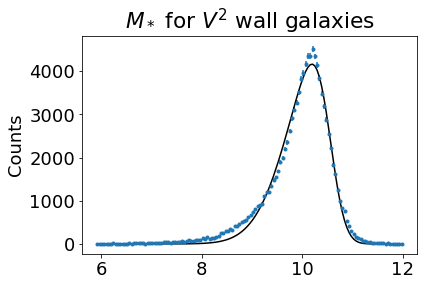

[ 4.64071485e+03  1.05393856e+01  7.27079143e-01 -2.90581646e+00] [4.04789416e+01 6.95150598e-03 1.12688324e-02 1.46176399e-01]
1184.6144515104259
2549799.4847640465


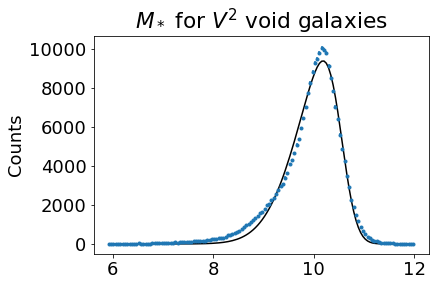

[ 1.06242945e+04  1.05357185e+01  7.42350054e-01 -2.95182331e+00] [9.51990547e+01 7.16839681e-03 1.17212223e-02 1.51937825e-01]


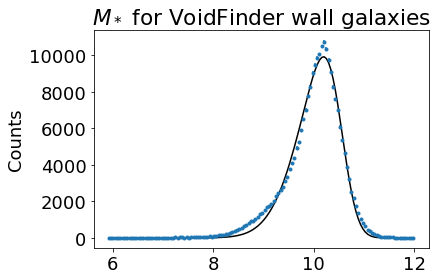

[ 1.06452221e+04  1.05326479e+01  6.77903663e-01 -2.53389501e+00] [8.57821288e+01 7.02348527e-03 1.05106594e-02 1.23363808e-01]


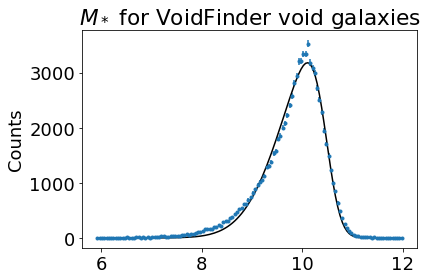

[ 3.80842883e+03  1.04643220e+01  8.09402416e-01 -3.40841258e+00] [2.95046348e+01 5.85058317e-03 1.03084888e-02 1.48039050e-01]


In [19]:



#print("\n wall_vf")
k = bin_data(Mstar_NSA[wall_vf], bins_=Mstar_bins)
x, poiss_err = k[0], k[2]
Mstar_NSA_VF_wall = fit_unimodal(char_=Mstar_NSA,
                                 class_=wall_vf,
                                 bins=Mstar_bins, 
                                 err=poiss_err,
                                 p0_=[ 2000,  10.5,  1.3, 1], 
                                 label='$M_*$ for VoidFinder wall galaxies')


#print("\n void_vf")
k = bin_data(Mstar_NSA[void_vf], bins_=Mstar_bins)
x, poiss_err = k[0], k[2]
Mstar_NSA_VF_void = fit_unimodal(char_=Mstar_NSA,
                                 class_=void_vf,
                                 bins=Mstar_bins, 
                                 err=poiss_err,
                                 p0_=[ 2000,  10.5,  1.3, 1], 
                                 label='$M_*$ for VoidFinder void galaxies')

## $M_r$ mean 

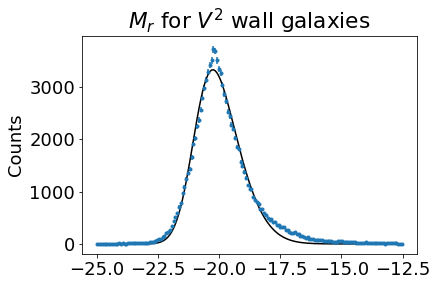

[ 7.50254969e+03 -2.09595514e+01  1.34845320e+00  2.07395435e+00] [6.08553710e+01 1.84697456e-02 2.42056506e-02 1.13623722e-01]


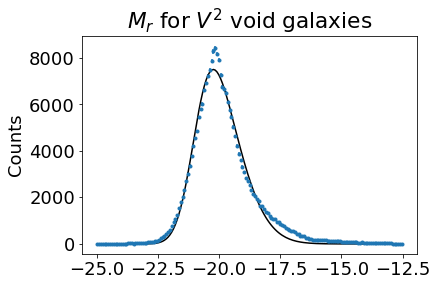

[ 1.71403882e+04 -2.09531636e+01  1.37826490e+00  2.12942706e+00] [1.47324571e+02 1.92483278e-02 2.56965935e-02 1.21422419e-01]


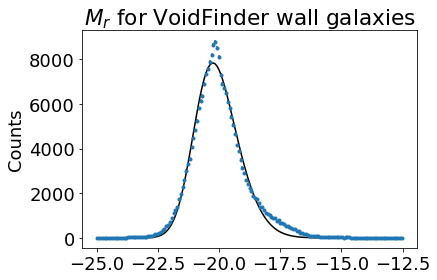

[ 1.72166632e+04 -2.09237989e+01  1.25681746e+00  1.76481061e+00] [1.36835939e+02 2.17360992e-02 2.52686588e-02 1.08182831e-01]


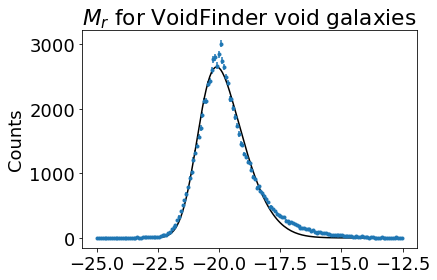

[ 6.10638340e+03 -2.08252247e+01  1.43860231e+00  2.41436257e+00] [4.96568406e+01 1.59934569e-02 2.32207236e-02 1.21247347e-01]


In [15]:
#print("wall_v2")
k = bin_data(rabsmag_NSA[wall_v2], bins_=np.linspace(-25,-12.5, 170))
x, poiss_err = k[0], k[2]
rabsmag_NSA_V2_wall_fit = fit_unimodal(char_=rabsmag_NSA,
                                       class_=wall_v2,
                                       bins=np.linspace(-25,-12.5, 170), 
                                       err=poiss_err,p0_=[ 2000,  -20,  1.3, 1], 
                                       label='$M_r$ for $V^2$ wall galaxies')


#print("\n void_v2")
k = bin_data(rabsmag_NSA[void_v2], bins_=np.linspace(-25,-12.5, 170))
x, poiss_err = k[0], k[2]
rabsmag_NSA_V2_void_fit = fit_unimodal(char_=rabsmag_NSA,
                                       class_=void_v2,
                                       bins=np.linspace(-25,-12.5, 170), 
                                       err=poiss_err,p0_=[ 2000,  -20,  1.3, 1], 
                                       label='$M_r$ for $V^2$ void galaxies')


#print("\n wall_vf")
k = bin_data(rabsmag_NSA[wall_vf], bins_=np.linspace(-25,-12.5, 170))
x, poiss_err = k[0], k[2]
rabsmag_NSA_VF_wall_fit = fit_unimodal(char_=rabsmag_NSA,
                                       class_=wall_vf,
                                       bins=np.linspace(-25,-12.5, 170), 
                                       err=poiss_err,p0_=[ 2000,  -20,  1.3, 1], 
                                       label='$M_r$ for VoidFinder wall galaxies')


#print("\n void_vf")
k = bin_data(rabsmag_NSA[void_vf], bins_=np.linspace(-25,-12.5, 170))
x, poiss_err = k[0], k[2]
rabsmag_NSA_VF_void_fit = fit_unimodal(char_=rabsmag_NSA,
                                       class_=void_vf,
                                       bins=np.linspace(-25,-12.5, 170), 
                                       err=poiss_err,p0_=[ 2000,  -20,  1.3, 1], 
                                       label='$M_r$ for VoidFinder void galaxies')

## $u-r$ mean

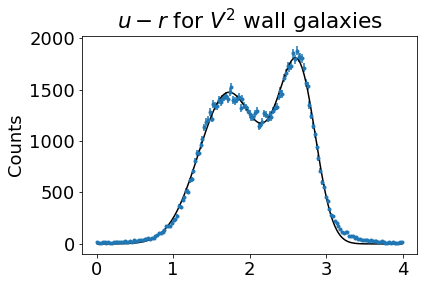

[ 1.39158020e+03  1.71763248e+00  3.81355991e-01 -6.10808736e-03
  1.09597717e+03  2.80567523e+00  3.43648956e-01 -1.42624558e+00] [4.57350584e+01 7.52066916e+02 3.65713136e+00 2.47177416e+03
 4.52287541e+01 1.31802436e-02 2.28914457e-02 2.05172792e-01]


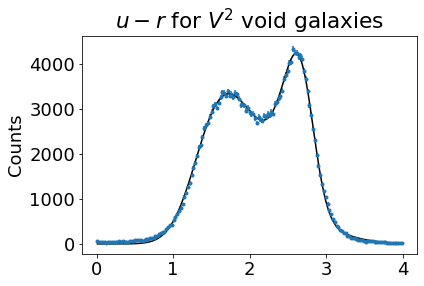

[ 4.12619990e+03  1.33485885e+00  7.91090593e-01  2.65672672e+00
  1.60325063e+03  2.78513607e+00  2.73324724e-01 -1.39117595e+00] [3.14365411e+01 4.01901234e-03 9.69520717e-03 6.93469093e-02
 2.43424570e+01 5.53555736e-03 6.05246378e-03 8.87337874e-02]


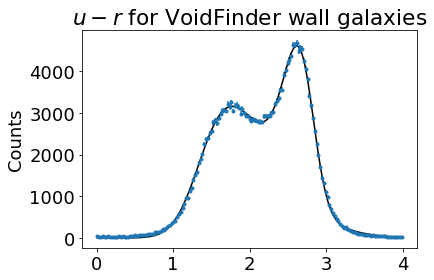

[ 1.79269778e+03  2.79307712e+00  2.77194170e-01 -1.44850825e+00
  3.91260220e+03  1.37407525e+00  7.92639064e-01  2.65563510e+00] [2.28752727e+01 4.60588899e-03 5.30717681e-03 7.84340903e-02
 2.98334541e+01 4.18272125e-03 9.30151097e-03 6.92884022e-02]


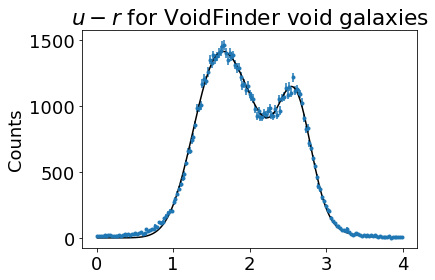

[1.58696222e+03 1.29555504e+00 7.02366369e-01 2.45966920e+00
 4.23458949e+02 2.54011077e+00 2.17901646e-01 3.68961387e-01] [2.07771160e+01 6.91270810e-03 1.87791570e-02 1.26852286e-01
 1.83551026e+01 1.24619408e-01 3.59347075e-02 8.25811657e-01]


In [18]:
# a, mua, sga, askew, b, mub, sgb, bskew

#print("wall_v2")
k = bin_data(u_r_NSA[wall_v2], bins_=np.linspace(0,4, 170))
x, poiss_err = k[0], k[2]
ur_NSA_V2_wall_fit = fit_bimodal(char_=u_r_NSA,
                                 class_=wall_v2,
                                 bins=np.linspace(0,4, 170), 
                                 err=poiss_err, 
                                 label='$u-r$ for $V^2$ wall galaxies')#,p0_=[ 2000,  1.5,  1.3, 1,2000,2.7,1,1])


#print("\n void_v2")
k = bin_data(u_r_NSA[void_v2], bins_=np.linspace(0,4, 170))
x, poiss_err = k[0], k[2]
ur_NSA_V2_void_fit = fit_bimodal(char_=u_r_NSA,
                                 class_=void_v2,
                                 bins=np.linspace(0,4, 170), 
                                 err=poiss_err, 
                                 label='$u-r$ for $V^2$ void galaxies')


#print("\n wall_vf")
k = bin_data(u_r_NSA[wall_vf], bins_=np.linspace(0,4, 170))
x, poiss_err = k[0], k[2]
ur_NSA_VF_wall_fit = fit_bimodal(char_=u_r_NSA,
                                 class_=wall_vf,
                                 bins=np.linspace(0,4, 170), 
                                 err=poiss_err, 
                                 p0_=[1500,  2.8,  0.25, -1.5, 3500, 1.25, 0.75, 2.75],
                                 label='$u-r$ for VoidFinder wall galaxies')


#print("\n void_vf")
k = bin_data(u_r_NSA[void_vf], bins_=np.linspace(0,4, 170))
x, poiss_err = k[0], k[2]
ur_NSA_VF_void_fit = fit_bimodal(char_=u_r_NSA,
                                 class_=void_vf,
                                 bins=np.linspace(0,4, 170), 
                                 err=poiss_err,
                                 p0_=[2000,  1.5,  1.3, 1, 2000, 2.7, 1, 1], 
                                 label='$u-r$ for VoidFinder void galaxies')

## $g-r$ means

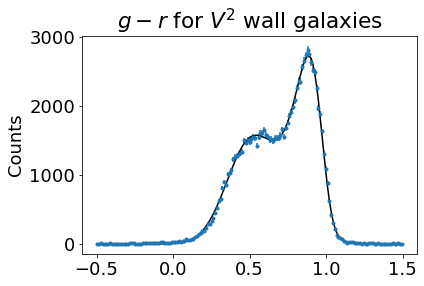

[ 5.63666272e+02  9.66449323e-01  1.42843127e-01 -2.33478126e+00
  7.01147282e+02  3.94002544e-01  2.44492625e-01  1.44050201e+00] [1.93273598e+01 1.33378004e-03 3.51808654e-03 9.95480423e-02
 2.09041040e+01 8.77355174e-03 1.50908765e-02 1.83757070e-01]


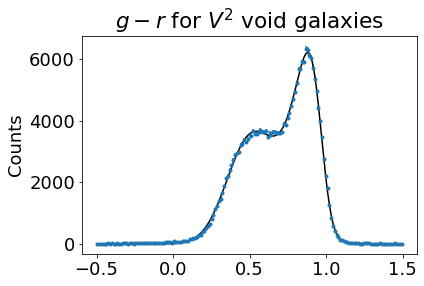

[ 1.59387961e+03  3.94839351e-01  2.40370777e-01  1.44402832e+00
  1.29128444e+03  9.61700279e-01  1.43684472e-01 -2.33701591e+00] [3.67821633e+01 6.37323942e-03 1.12620168e-02 1.38049908e-01
 3.42509523e+01 9.79880266e-04 2.69144572e-03 7.31361928e-02]


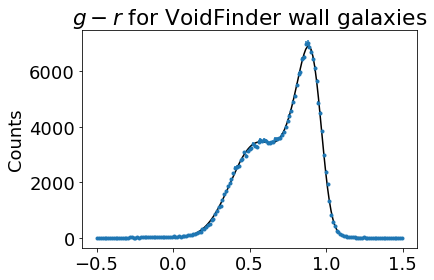

[ 1.48085128e+03  4.26440612e-01  2.25630960e-01  1.20742056e+00
  1.38892263e+03  9.61720895e-01  1.36550052e-01 -2.30969481e+00] [3.43766498e+01 8.82471108e-03 1.21370817e-02 1.51765103e-01
 3.19841282e+01 8.19788122e-04 2.22492385e-03 6.42414637e-02]


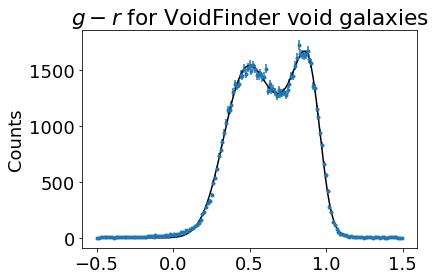

[ 3.55552175e+02  9.52877972e-01  1.55263914e-01 -2.31959977e+00
  6.59678429e+02  3.57750967e-01  2.47140820e-01  1.73433942e+00] [2.14710914e+01 2.06017603e-03 6.48089784e-03 1.39488386e-01
 2.25811089e+01 5.88889768e-03 1.47936957e-02 1.84110946e-01]


In [19]:
# a, mua, sga, askew, b, mub, sgb, bskew

#print("wall_v2")
k = bin_data(g_r_NSA[wall_v2], bins_=np.linspace(-0.5,1.5, 170))
x, poiss_err = k[0], k[2]
gr_NSA_V2_wall_fit = fit_bimodal(char_=g_r_NSA,
                                 class_=wall_v2,
                                 bins=np.linspace(-0.5,1.5, 170), 
                                 err=poiss_err, 
                                 label='$g-r$ for $V^2$ wall galaxies')#,p0_=[ 2000,  1.5,  1.3, 1,2000,2.7,1,1])


#print("\n void_v2")
k = bin_data(g_r_NSA[void_v2], bins_=np.linspace(-0.5,1.5, 170))
x, poiss_err = k[0], k[2]
gr_NSA_V2_void_fit = fit_bimodal(char_=g_r_NSA,
                                 class_=void_v2,
                                 bins=np.linspace(-0.5,1.5, 170), 
                                 err=poiss_err, 
                                 label='$g-r$ for $V^2$ void galaxies')


#print("\n wall_vf")
k = bin_data(g_r_NSA[wall_vf], bins_=np.linspace(-0.5,1.5, 170))
x, poiss_err = k[0], k[2]
gr_NSA_VF_wall_fit = fit_bimodal(char_=g_r_NSA, 
                                 class_=wall_vf,
                                 bins=np.linspace(-0.5,1.5, 170), 
                                 err=poiss_err, 
                                 label='$g-r$ for VoidFinder wall galaxies')


#print("\n void_vf")
k = bin_data(g_r_NSA[void_vf], bins_=np.linspace(-0.5,1.5, 170))
x, poiss_err = k[0], k[2]
gr_NSA_VF_void_fit = fit_bimodal(char_=g_r_NSA,
                                 class_=void_vf,
                                 bins=np.linspace(-0.5,1.5, 170), 
                                 err=poiss_err,
                                 p0_=np.array([ 8.85731778e+02,  9.84204392e-01,  8.07998114e-02, -3.33639653e+00, 1.39274659e+03,  4.75774665e-01,  2.82524710e-01,  1.32105068e+00]), 
                                 label='$g-r$ for VoidFinder void galaxies')

## SFR

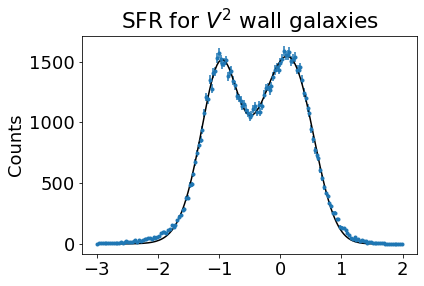

[ 1.88552377e+03  4.99062274e-01  7.47778593e-01 -2.25091304e+00
  9.30806212e+02 -7.89933937e-01  3.99050483e-01 -1.33707626e+00] [4.48196063e+01 1.36658804e-02 3.77172861e-02 2.06968102e-01
 4.39950693e+01 1.11286489e-02 1.03570723e-02 1.31933701e-01]


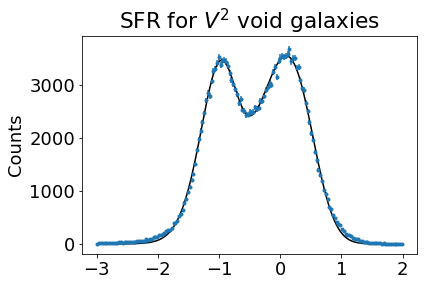

[ 4.35545926e+03  4.86236620e-01  7.55169312e-01 -2.32025155e+00
  2.09096529e+03 -7.93628014e-01  4.04302385e-01 -1.44362132e+00] [8.10083493e+01 1.04091322e-02 2.94992052e-02 1.65193910e-01
 7.93460100e+01 8.25437783e-03 8.17595304e-03 1.05289749e-01]


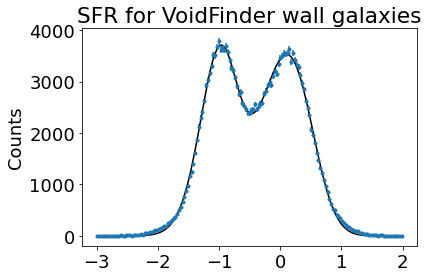

[ 2.44753715e+03 -7.99398551e-01  3.91800795e-01 -1.22616824e+00
  4.09049209e+03  4.70178328e-01  6.83316386e-01 -1.95256844e+00] [7.35689357e+01 8.31140148e-03 7.21357646e-03 9.99996944e-02
 7.40851147e+01 1.27501872e-02 2.91321756e-02 1.58888423e-01]


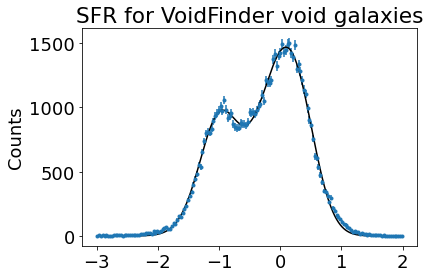

[ 6.26687805e+02 -8.28947524e-01  3.81249067e-01 -9.79443696e-01
  1.63966033e+03  4.40641852e-01  6.48529625e-01 -1.86026119e+00] [4.76826190e+01 3.11000444e-02 2.21429782e-02 2.95069907e-01
 4.78641610e+01 1.96508385e-02 4.40757394e-02 2.39937103e-01]


In [23]:
# a, mua, sga, askew, b, mub, sgb, bskew

#print("wall_v2")
k = bin_data(SFR[wall_v2], bins_=np.linspace(-3,2, 170))
x, poiss_err = k[0], k[2]
SFR_V2_wall_fit = fit_bimodal(char_=SFR,
                              class_=wall_v2,
                              bins=np.linspace(-3,2, 170), 
                              err=poiss_err, 
                              p0_=[4000, 0.5, 0.75, -2.25, 2000, -0.75, 0.5, -1.5], 
                              label='SFR for $V^2$ wall galaxies')


#print("\n void_v2")
k = bin_data(SFR[void_v2], bins_=np.linspace(-3,2, 170))
x, poiss_err = k[0], k[2]
SFR_V2_void_fit = fit_bimodal(char_=SFR,
                              class_=void_v2,
                              bins=np.linspace(-3,2, 170), 
                              err=poiss_err, 
                              label='SFR for $V^2$ void galaxies')


#print("\n wall_vf")
k = bin_data(SFR[wall_vf], bins_=np.linspace(-3,2, 170))
x, poiss_err = k[0], k[2]
SFR_VF_wall_fit = fit_bimodal(char_=SFR,
                              class_=wall_vf,
                              bins=np.linspace(-3,2, 170), 
                              err=poiss_err, 
                              p0_=[2000, -1.5, 1.3, 1, 2000, 0.7, 1, 1], 
                              label='SFR for VoidFinder wall galaxies')


#print("\n void_vf")
k = bin_data(SFR[void_vf], bins_=np.linspace(-3,2, 170))
x, poiss_err = k[0], k[2]
SFR_VF_void_fit = fit_bimodal(char_=SFR,
                              class_=void_vf,
                              bins=np.linspace(-3,2, 170), 
                              err=poiss_err,
                              p0_=[2000,  -1.5,  1.3, 1, 2000, 0.7, 1, 1], 
                              label='SFR for VoidFinder void galaxies')

## sSFR means

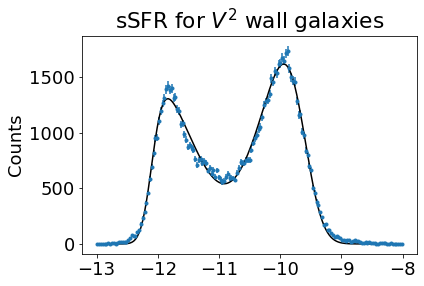

[ 1.61032510e+03 -9.62276403e+00  6.25054874e-01 -2.44614719e+00
  1.21301142e+03 -1.20939567e+01  6.62265516e-01  4.58613900e+00] [2.09842485e+01 7.84929136e-03 1.67835304e-02 1.51713397e-01
 2.11004092e+01 5.14654035e-03 1.81096884e-02 3.04246232e-01]


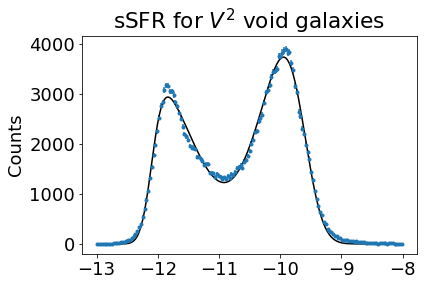

[ 3.71459863e+03 -9.62660716e+00  6.19582121e-01 -2.38270305e+00
  2.74176335e+03 -1.20953449e+01  6.64529676e-01  4.57743801e+00] [4.09295495e+01 6.84996990e-03 1.42735346e-02 1.27090696e-01
 4.12244405e+01 4.49313295e-03 1.57784019e-02 2.63771394e-01]


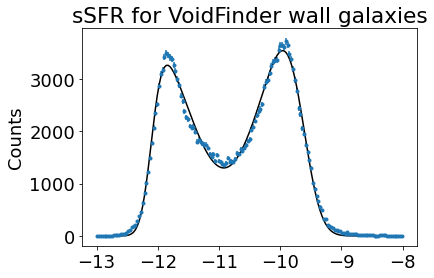

[ 3.61034304e+03 -9.63327539e+00  6.57089625e-01 -2.69955606e+00
  2.92040753e+03 -1.21004571e+01  6.35768833e-01  4.35667469e+00] [4.48410171e+01 6.84089452e-03 1.61886212e-02 1.51858429e-01
 4.45455053e+01 4.35906001e-03 1.50046882e-02 2.44723708e-01]


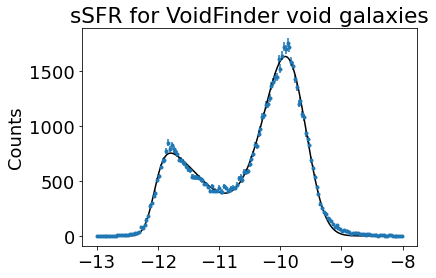

[ 1.46645695e+03 -9.63005965e+00  5.21611439e-01 -1.79463766e+00
  8.00659553e+02 -1.20547533e+01  7.79850678e-01  5.80919620e+00] [1.63316410e+01 8.03592375e-03 1.26685895e-02 1.05322355e-01
 1.71593883e+01 6.17262690e-03 2.59861372e-02 4.83127559e-01]


In [24]:
# a, mua, sga, askew, b, mub, sgb, bskew

#print("wall_v2")
k = bin_data(sSFR[wall_v2], bins_=np.linspace(-13,-8, 170))
x, poiss_err = k[0], k[2]
sSFR_V2_wall_fit = fit_bimodal(char_=sSFR,
                               class_=wall_v2,
                               bins=np.linspace(-13,-8, 170), 
                               err=poiss_err,
                               p0_=[1800, -9.6, 0.7, -3, 1300, -12.1, 0.6, 4], 
                               label='sSFR for $V^2$ wall galaxies')


#print("\n void_v2")
k = bin_data(sSFR[void_v2], bins_=np.linspace(-13,-8, 170))
x, poiss_err = k[0], k[2]
sSFR_V2_void_fit = fit_bimodal(char_=sSFR,
                               class_=void_v2,
                               bins=np.linspace(-13,-8, 170), 
                               err=poiss_err,
                               p0_=[2000, -9.8, 1.3, 1, 2000, -11.9, 1, 1], 
                               label='sSFR for $V^2$ void galaxies')


#print("\n wall_vf")
k = bin_data(sSFR[wall_vf], bins_=np.linspace(-13,-8, 170))
x, poiss_err = k[0], k[2]
sSFR_VF_wall_fit = fit_bimodal(char_=sSFR,
                               class_=wall_vf,
                               bins=np.linspace(-13,-8, 170), 
                               err=poiss_err,
                               p0_=[ 2000,  -9.8,  1.3, 1,2000,-11.5,1,1], 
                               label='sSFR for VoidFinder wall galaxies')


#print("\n void_vf")
k = bin_data(sSFR[void_vf], bins_=np.linspace(-13,-8, 170))
x, poiss_err = k[0], k[2]
sSFR_VF_void_fit = fit_bimodal(char_=sSFR,
                               class_=void_vf,
                               bins=np.linspace(-13,-8, 170), 
                               err=poiss_err,
                               p0_=[ 2000,  -9.8,  1.3, 1,2000,-11.5,1,1], 
                               label='sSFR for VoidFinder void galaxies')

# Extract the mean and the error in the mean from the fit results

### Calculate averages and medians

In [31]:
def remove_nan(array):
    '''
    Remove both nan and inf values from array
    '''
    #return array[np.logical_not(np.isnan(array))]
    return array[np.isfinite(array)]

In [29]:
def stat(char_, voidfinder=False):
    '''
    PARAMETERS
    ==========
    char_ : 
        array with galaxy properties, e.g., Mstar
    
    voidfinder : boolean
        True if we want to calculate the statistics of VoidFinder data and not V2 data
    
    
    note 1 : shifts are taken as (void - wall)
    
    note 2 : percent difference are calculated with respect to the wall distribution
    
    
    RETURNS
    =======
    average
    std of average
    average shift
    std of average shift
    percent diff of avg
    median
    median shift
    percent diff of median
    '''
    
    if voidfinder:
        char_void = remove_nan(char_[void_vf])
        char_wall = remove_nan(char_[wall_vf])
        
    else:
        char_void = remove_nan(char_[void_v2])
        char_wall = remove_nan(char_[wall_v2])
        
    avg_void = np.mean(char_void)
    avg_wall = np.mean(char_wall)
        
    avg_shift = avg_wall-avg_void
        
    std_avg_void = np.std(char_void, ddof=1)/np.sqrt(len(char_void))
    std_avg_wall = np.std(char_wall, ddof=1)/np.sqrt(len(char_wall))
    
    std_avg_shift = np.sqrt(std_avg_void**2 + std_avg_wall**2)
        
    percent_diff_avg = (avg_shift/avg_wall)*100
    
    median_wall = np.median(char_wall)
    median_void = np.median(char_void)
    
    median_shift = median_wall-median_void
    
    percent_diff_median = (median_shift/median_wall)*100
    
    mode_wall = stats.mode(char_wall, axis=None)[0][0]
    mode_void = stats.mode(char_void, axis=None)[0][0]
    
    mode_shift = mode_wall-mode_void
    percent_diff_mode = (mode_shift/mode_wall)*100
    
    print('average void : %.3f \pm %.3f' %(avg_void, std_avg_void))
    print('median void : %.3f' %median_void)
    print('average shift w.r.t wall :  %.3f \pm %.3f'%(avg_shift, std_avg_shift))
    print('percent difference in avg w.r.t wall : %.3f percent' %(percent_diff_avg))
    print('median shift w.r.t wall: %.3f' %median_shift)
    print('percent difference in median w.r.t wall : %.3f percent' %percent_diff_median)
    print("\n")
    print('average wall :  %.3f \pm %.3f'%(avg_wall, std_avg_wall))
    print('median wall : %.3f' %median_wall)
    print("\n")
    
#     print('mode void : ', mode_void)
#     print('mode wall : ', mode_wall)
#     print('percent difference in mode w.r.t wall : ', percent_diff_mode)

In [32]:
print("\t \tStellar Mass \n")
print("--------------------VOIDFINDER--------------------------- \n")
stat(Mstar_NSA, voidfinder=True)
print("\n----------------------V2------------------------- \n")
stat(Mstar_NSA)
print("----------------------------------------------- \n")

print("\t \tu-r \n")
print("--------------------VOIDFINDER--------------------------- \n")
stat(u_r_NSA, voidfinder=True)
print("\n----------------------V2------------------------- \n")
stat(u_r_NSA)
print("----------------------------------------------- \n")

print("\t \tg-r \n")
print("--------------------VOIDFINDER--------------------------- \n")
stat(g_r_NSA, voidfinder=True)
print("\n----------------------V2------------------------- \n")
stat(g_r_NSA)
print("----------------------------------------------- \n")

print("\t \tAbsolute Magnitude \n")
print("--------------------VOIDFINDER--------------------------- \n")
stat(rabsmag_NSA, voidfinder=True)
print("\n----------------------V2------------------------- \n")
stat(rabsmag_NSA)
print("----------------------------------------------- \n")

print("\t \tStar formation Rate \n")
print("--------------------VOIDFINDER--------------------------- \n")
stat(SFR, voidfinder=True)
print("\n----------------------V2------------------------- \n")
stat(SFR)
print("----------------------------------------------- \n")

print("\t \tSpecific Star Formation Rate \n")
print("--------------------VOIDFINDER--------------------------- \n")
stat(sSFR, voidfinder=True)
print("\n----------------------V2------------------------- \n")
stat(sSFR)
print("----------------------------------------------- \n")

	 	Stellar Mass 

--------------------VOIDFINDER--------------------------- 

average void : 9.792 \pm 0.002
median void : 9.915
average shift w.r.t wall :  0.147 \pm 0.002
percent difference in avg w.r.t wall : 1.476 percent
median shift w.r.t wall: 0.101
percent difference in median w.r.t wall : 1.007 percent


average wall :  9.939 \pm 0.001
median wall : 10.016



----------------------V2------------------------- 

average void : 10.049 \pm 0.002
median void : 10.178
average shift w.r.t wall :  0.004 \pm 0.003
percent difference in avg w.r.t wall : 0.041 percent
median shift w.r.t wall: -0.003
percent difference in median w.r.t wall : -0.026 percent


average wall :  10.054 \pm 0.002
median wall : 10.176


----------------------------------------------- 

	 	u-r 

--------------------VOIDFINDER--------------------------- 

average void : 1.965 \pm 0.002
median void : 1.920
average shift w.r.t wall :  0.162 \pm 0.002
percent difference in avg w.r.t wall : 7.612 percent
median shift 

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_1837/2997052487.py:60: RuntimeWarning: invalid value encountered in double_scalars
  percent_diff_mode = (mode_shift/mode_wall)*100


average void : -19.630 \pm 0.004
median void : -19.845
average shift w.r.t wall :  -0.229 \pm 0.005
percent difference in avg w.r.t wall : 1.155 percent
median shift w.r.t wall: -0.115
percent difference in median w.r.t wall : 0.576 percent


average wall :  -19.860 \pm 0.002
median wall : -19.960



----------------------V2------------------------- 

average void : -20.132 \pm 0.004
median void : -20.368
average shift w.r.t wall :  -0.009 \pm 0.006
percent difference in avg w.r.t wall : 0.044 percent
median shift w.r.t wall: 0.007
percent difference in median w.r.t wall : -0.036 percent


average wall :  -20.141 \pm 0.005
median wall : -20.361


----------------------------------------------- 

	 	Star formation Rate 

--------------------VOIDFINDER--------------------------- 

average void : -0.302 \pm 0.002
median void : -0.215
average shift w.r.t wall :  -0.132 \pm 0.003
percent difference in avg w.r.t wall : 30.455 percent
median shift w.r.t wall: -0.200
percent difference in medi